<center>
<img src='https://alexanderdyakonov.files.wordpress.com/2019/05/d0b01.jpg' align='center' width="400x">
</center>

# Андан на экономе

## Семинар 9:  Метрики классификации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

На прошлом семинаре мы обучили логистическую регрессию для предсказания оттока пользователей. Давайте воспроизведём тот код.

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('telecom_churn.csv')

categorical_features = ['State', 'Area code', 'International plan', 'Voice mail plan']

numeric_features = [
    'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 
    'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes',
    'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 
    'Total intl charge', 'Customer service calls', 'Account length'
]

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Churn'])

y_train = df_train['Churn']
y_test = df_test['Churn'] 
X_train = df_train.drop('Churn', axis=1)
X_test = df_test.drop('Churn', axis=1)

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),    
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first",
                         min_frequency=0.01), categorical_features)
])

model = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(C=0.1833))
])

model.fit(X_train, y_train);

p_pred = model.predict_proba(X_test)

Давайте выясним, насколько наша модель оказалась хорошей. Заодно разберёмся в том, какими бывают метрики качества классификации.

## 1. Метрики, которые зависят от порога

В переменной `p_pred` два столбца. В первом вероятность того, что пользователь останется, $P(y = 0 \mid x).$ Во втором вероятность того, что пользователь уйдёт из сервиса $P(y = 1 \mid x).$

In [4]:
p_pred

array([[0.83516874, 0.16483126],
       [0.83466763, 0.16533237],
       [0.93545703, 0.06454297],
       ...,
       [0.80553897, 0.19446103],
       [0.93921858, 0.06078142],
       [0.82715661, 0.17284339]])

In [5]:
p_pred = p_pred[:, -1]

Давайте будем считать, что мы предсказываем $y_i = 1$, если значение $p_i = P(y_i = 1 \mid x_i)$ оказалось больше порога $t$. Метод `.predict` берёт в качестве порога значение $0.5$.

In [6]:
y_pred = model.predict(X_test)
y_pred[:4]

array([False, False, False, False])

In [8]:
np.all((p_pred >= 0.5) == y_pred)

np.True_

Давайте возьмём $t = 0.5$ и посчитаем метрики качества модели. 

In [9]:
t = 0.5
y_pred = 1*(p_pred >= t) 

Предсказывая отток, мы можем совершить ошибки двух видов: 

* Ошибка первого рода: мы предсказали человеку, что он уйдёт, а он остался.
* Ошибка второго рода: мы предсказали, что человек останется, а он ушёл.

В разных задачах критичны разные виды ошибок. На основе этих ошибок можно придумать много метрик. Все они будут строиться на базе __матрицы ошибок.__

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[563,   7],
       [ 84,  13]])

Давайте сделаем красивую картинку.

In [11]:
import itertools

def conf_matrix_pic(y_test, y_pred, cm_normalize=True):
    """
        Отрисовка confusion matrix
    """
    cm = confusion_matrix(y_test, y_pred)
    if cm_normalize:
        cm = np.round(100*cm.astype('float') / cm.sum(), 1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion matrix', size=16)
    
    classes = ['0', '1']
    tick_marks = np.arange(len(classes))
    
    fmt = '.2f' if cm_normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(i, j, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=30)

    ax.set_xlabel('True label', fontsize=16)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_xlim(-0.5, 1.5)

    ax.set_ylabel('Predicted label', fontsize=16)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.set_ylim(-0.5, 1.5)

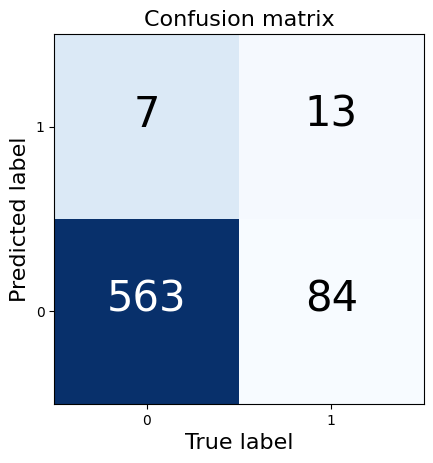

In [12]:
conf_matrix_pic(y_test, y_pred, cm_normalize=False)

__Вопрос:__ сколько объектов нулевого/первого класса мы классифицировали верно? Сколько ошибок первого и второго рода мы совершили? 

Обычно для клеток матрицы ошибок используют следующие обозначения. Через них мы запишем все основные метрики классификации. 

<center>
<img src='https://miro.medium.com/v2/1*tfgp1czHTBMfSbIM2EHnNA.png' align='center' width="800x">
</center>

Ещё часто можно встретить такую картинку:

<center>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Binary-classification-labeled.svg/1920px-Binary-classification-labeled.svg.png' align='center' width="250x">
</center>

Поговорим о каждой метрике более детально!

**Доля верно классифицированных объектов (Accuracy):**

$$
Accuracy = \frac{TP + TN}{TP + FP + TN + FN}
$$

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.863568215892054

Интуитивно понятная, очевидная и почти неиспользуемая метрика. У неё есть две проблемы. Во-первых, она бесполезна в задачах с неравными классами. 

Например, пусть у нас есть $50$ больных и $950$ здоровых. Мы хотим научиться их различать. Пусть наш алгоритм предсказывает, что все здоровы. В этом случае доля правильных ответов составит $95\%$, но алгорим окажется абсолютно бесполезным. 

Чтобы «бороться» с этой проблемой, используется следующий факт. Пусть $q_0$ — доля объектов самого крупного класса, тогда доля правильных ответов для разумных алгоритмов $accuracy \in [q_0; 1]$, а не $[0.5; 1]$, как это можно было бы ожидать. Поэтому, если получается высокий процент правильных ответов, это может быть связано не с тем, что построен хороший классификатор, а с тем, что какого-то класса сильно больше, чем остальных.

In [14]:
# предскажим на всех объектах нули
accuracy_score(np.zeros_like(y_test), y_test)

0.8545727136431784

Вторая проблема с долей верных ответов состоит в том, что она никак не учитывает разные цены разных типов ошибок. 

В разных ситуациях ошибки имеют разные цены. $Accuracy$ не видит этого, поэтому на практике обычно используют $Precision$ и $Recall$. Довольно часто $Precision$ заменяют на $FPR$.

**Точность (precision):**

$$
Precision = \frac{TP}{TP + FP}
$$

Отражает то, насколько мы можем доверять алгоритму, если он спрогнозировал единичку.

**Полнота (Recall):**

$$
Recall = \frac{TP}{TP + FN}
$$

Показывает, как много объектов первого класса наш алгоритм находит, то есть метрика демонстрирует способность алгоритма обнаруживать данный класс вообще

**Доля неверно классифицированных положительных примеров (FPR):**

$$
FPR = \frac{FP}{FP + TN}
$$

FPR показывает, какую долю из объектов negative класса алгоритм предсказал неверно.

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.65

In [16]:
recall_score(y_test, y_pred)

0.13402061855670103

In [17]:
def false_positive_rate(y_test, y_pred):
    return ((y_test == 0) & (y_pred == 1)).sum()/(y_test == 0).sum()

false_positive_rate(y_test, y_pred)

np.float64(0.012280701754385965)

Баланс между метриками выбирается с помощью порога $t$. Давайте подвигаем его.

In [18]:
t = 0.3
y_pred = 1*(p_pred >= t) 

print('Точность:', precision_score(y_test, y_pred))
print('Полнота:', recall_score(y_test, y_pred))
print('FPR:', false_positive_rate(y_test, y_pred))

Точность: 0.5362318840579711
Полнота: 0.38144329896907214
FPR: 0.056140350877192984


In [19]:
t = 0.5
y_pred = 1*(p_pred >= t) 

print('Точность:', precision_score(y_test, y_pred))
print('Полнота:', recall_score(y_test, y_pred))
print('FPR:', false_positive_rate(y_test, y_pred))

Точность: 0.65
Полнота: 0.13402061855670103
FPR: 0.012280701754385965


In [20]:
t = 0.7
y_pred = 1*(p_pred >= t) 

print('Точность:', precision_score(y_test, y_pred))
print('Полнота:', recall_score(y_test, y_pred))
print('FPR:', false_positive_rate(y_test, y_pred))

Точность: 1.0
Полнота: 0.030927835051546393
FPR: 0.0



- Чем выше точность, тем меньше полнота
- Чем меньше FPR, тем меньше полнота  

Баланс между этими метриками выбирается в зависимости от смысла задачи. Посмотрим на пару примеров: 

> Пусть мы пытаемся найти больных больной болезнью с болью и отправить их делать дополнительные анализы, для нас страшнее $FN$ ошибка. Если мы отправим лишнего человека на анализы, ничего страшного с ним не произойдёт. Если мы забудем проверить больного, он умрёт. Тут лучше добиться высокой полноты, при небольшой точности. 

> Пусть мы решаем задачу крединтого скоринга, выдаём пчёлам кредит, нам нужно получить деньги назад с процентом, иначе мы разоримся. Нам нужна модель, которая будет точно определять надёжного заёмщика. Для нас важно не потерять слишком много денег на плохих заёмщиках, поэтому мы пытаемся закрутить классификатор в точность. 

> Пусть мы решаем задачу модерации. Например, ищем в видео на youtube спам и баним эти видео. С одной стороны мы хотим найти весь спам на платформе, с другой стороны мы хотим, чтобы пострадало как можно меньше хороших видео. Если у нас есть штат модераторов либо бюджет для краудсорсинга, логично подобрать два порога. Порог для автоматического бана классификатором подберём так, чтобы $FPR$ был не очень высоким. Тогда хорошие авторы не будут массово прибегать в поддержку. Второй порог подберём так, чтобы у нас была высокая полнота и мы при этом не пробили ограничения по бюджету на разметку.

Обратите внимание на разницу между $Precision$ и $FPR$. Обе этих метрики отражают "точность" классификатора. $Precision$ считается по строке и говорит о том, какая доля банов из всех банов была справедливой. $FPR$ считается по столбцу и говорит о том, какая доля хороших ребят была забанена несправедливо. На практике может возникнуть ситуация, когда $Precision$ оказался низким, полнота тоже низкая, но при этом среди всех ноликов мы баним довольно маленькую долю и можно пожертвовать точностью ещё сильнее. 

Если вспомнить матстат, то можно проинтерпретировать $FPR$ как уровень значимости принятия решения, $\alpha$, то есть как ошибку первого рода. Величину $FNR = 1 - Recall$ можно проинтерпретировать как ошибку второго рода, $\beta$, а сам $Recall$ как мощность алгоритма. 

Есть и другие способы подбирать пороги. Например, в случае youtube можно ориентироваться не на число плохих видео, а на число плохих показов. Забанить хорошее видео с большими охватами намного страшнее, чем маленькое. Это можно учесть при подборе порога. 

Можно склеить точность и полноту в одну метрику, посчитав их среднее гармонческое и получить **f-меру (f-measure):** 

$$
f = (1 + \beta)^2 \cdot \frac{\beta^2 \cdot precision \cdot recall}{precision + recall}
$$

Параметр $\beta$ в данном случае определяет вес точности в метрике. $\beta = 1$ вносит точность и полноту с одинаковыми весами. Изменяя его, можно отдавать предпочтения либо одному либо другому. 

In [21]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.06

## 2. Метрики, которые  НЕ зависят от порога

Точность, полнота, FPR и accuracy зависят от выбора порога. А хотелось бы, чтобы та метрика, по которой мы выбираем модель, от порога не зависела. 

Давайте по оси $x$ откладывать полноту, а по оси $y$ точность. Будем по очереди перебирать разные пороги и считать для них точность и полноту. Нанесём на картинку все полученные точки и соединим их. Тогда у нас получится **precision-recall кривая.** 

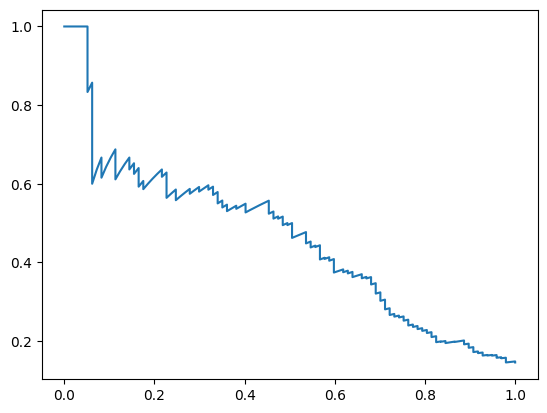

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

pr, rc, ct = precision_recall_curve(y_test, p_pred)
plt.plot(rc, pr);

In [23]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, p_pred)

np.float64(0.46157569850153074)

В случае идеального классификатора, то есть если существует такой порог, что и точность, и полнота равны $100\%$, кривая будет проходить через точку $(1, 1)$. Таким образом, чем ближе кривая пройдет к этой точке, тем лучше оценки. Площадь под этой кривой может быть хорошей мерой качества оценок принадлежности к классу $1$. Такая метрика называется **pr-auc, или площадь под PR-кривой.**

In [24]:
def plot_precision_recall_curve(y_test, p_pred):
    plt.figure(figsize=(7, 7))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
    pr_test = average_precision_score(y_test, p_pred)
    precision, recall, _ =  precision_recall_curve(y_test, p_pred)
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b', label='Test PR-AUC {0}'.format(pr_test))
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right');

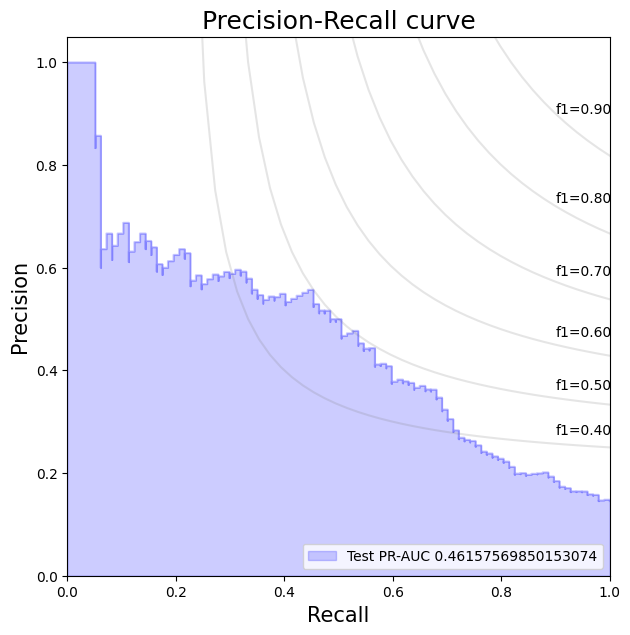

In [25]:
plot_precision_recall_curve(y_test, p_pred)

Если обратиться к микроэкономике, можно провести аналогию между pr-кривой и допустимым множеством товаров. Первый товар это Precision, второй это Recall. Между ними есть трейдофф. Мы можем задать его с помощью f-меры (кривые безразличия). Если мы хотим выбрать самый классный порог для принятия решения, мы можем максимизировать f-меру.

Более того, мы можем описать свои предпочтения с помощью какой-то другой функции полезности. Скорее всего, каждая ошибка классификатора будет стоить нам денег. В случае оттока, мы будем терять LTV юзера, если мы его не удержали либо мы будем тратить лишние деньги на удержание пользователей, которые вообще не собирались уходить. Можно включить эту стоимость ошибок в нашу f-меру и измерять полезность каждой точки в деньгах.

Давайте по оси $x$ откладывать $FPR$, а по оси $y$ откладывать $TPR = 1 - Recall$. Будем по очереди перебирать разные пороги и считать для них $FPR$ и $TPR$. Нанесём на картинку все полученные точки и соединим их. Тогда у нас получится **ROC-кривая.**  Площадь под ней будет показывать насколько классификатор хорош с точки зрения FPR и Recall, она называется **ROC-AUC.**

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def roc_auc_pic(y_test, p_pred):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, p_pred)
    roc_auc_test = roc_auc_score(y_test, p_pred)

    plt.figure(figsize=(7, 7))
    plt.plot(fpr_test, tpr_test, label='Test ROC-AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right');

In [27]:
roc_auc_score(y_test, p_pred)

np.float64(0.7733224814613854)

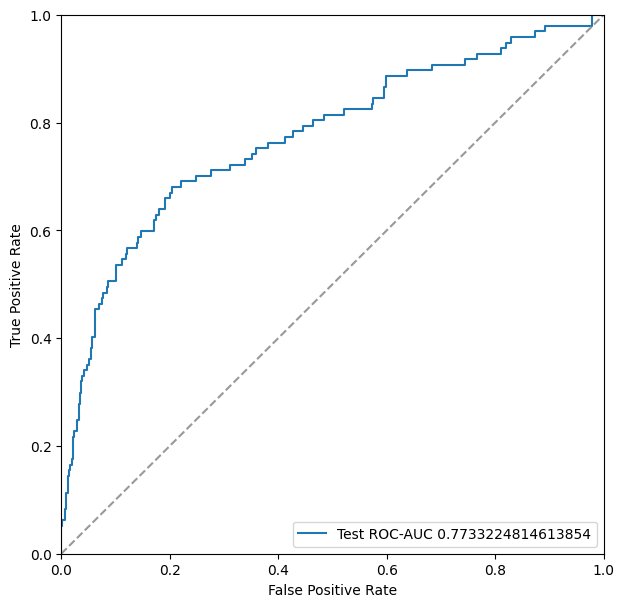

In [28]:
roc_auc_pic(y_test, p_pred)

У площади под roc-auc есть более простая интепретация. Это доля верно классифицированных пар объектов. Давайте посмотрим на конкретную задачку, чтобы понять эту мысль. 

__Упражнение:__ 

Пусть у нас есть выборка и вероятности из классификатора:

\begin{equation*}
\begin{matrix}
& y_i & 1   & 0   & 0   & 1    & 0   \\
& p_i & 0.7 & 0.2 & 0.3 & 0.25 & 0.1 \\
\end{matrix}
\end{equation*}

Найдите значение ROC AUC.

Возьмём два объекта разного класса. Модель предсказывает нам $P(y_i = 1 \mid x_i)$. 

\begin{equation} 
\begin{aligned}
    &y_1 = 1   \qquad & P(y_1 = 1 \mid x_1) = p(x_1)\\ 
    &y_2 = 0  \qquad  & P(y_2 = 1 \mid x_2) = p(x_2)\\ 
\end{aligned}
\end{equation} 

Если у нас хорошая модель, то явно $p(x_1) > p(x_2)$. Иначе модель всё путает и говорит, что нолики это единицы. Давайте посмотрим, как часто на нашей выборке такая путаница происходит и **рассмотрим все возможные пары нулей и единичек.** Всего будет шесть пар. 

\begin{equation} 
\begin{aligned}
& 0.7 > 0.2 \qquad & ok \\
& 0.7 > 0.3 \qquad & ok \\
& 0.7 > 0.1 \qquad & ok \\
& 0.25 > 0.2 \qquad & ok \\ 
& 0.25 < 0.3 \qquad & not \mbox{ } ok \\
& 0.25 > 0.1 \qquad & ok \\
\end{aligned}
\end{equation} 

Видим, что модель ошиблась в упорядочивании один раз. $roc\_auc$ - это доля пар, где модель оказалась права. В нашем случае это $\frac{5}{6}$. Площадь под roc-кривой принимает значения от $0.5$ до $1$. Если у нас $0.5$, то классификатор упорядочивает как монетка.

In [29]:
# сгенерим прогнозы вероятностей из равномерного распределения
roc_auc_score(y_test, np.random.random(y_test.size))

np.float64(0.5300235123892205)

__Вопрос:__ запустите код ниже, посмотрите на получившуюся картинку и скажите, что было сделано неправильно.

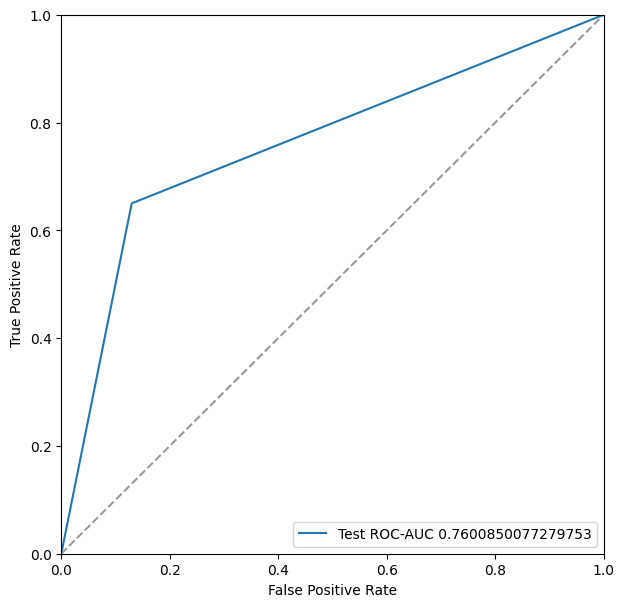

In [30]:
p_pred = model.predict(X_test)
roc_auc_pic(p_pred, y_test)

## 4. Задания

Осталось время? 

1. Обучите на тех же самых данных KNN и сравните его по pr-auc и roc-auc с логистической регрессией.
2. Нарисуйте ROC-кривую для KNN и ROC-кривую для логистической регрессии на одном графике
3. Подбирите для логистической регрессии пороги принятия решений. Бизнес-правила для принятия решения продумайте сами. Нанисите точку с выбранным порогом на график с ROC-кривой. 
4. Посмотри [няшную визуализацию про ROC-кривую от Насти Чирковой.](https://kawaiiuroboros.github.io/roc-auc/) Что отложено по горизонтали и вертикали на левом и правом графике? При каких условиях в визуализации AUC меньше половины?

## 5. Что почитать? 

- [Лекция Жени Соколова про метрики классификации](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/lecture-notes/lecture05-linclass.pdf)
- [Конспект Фила с задачами про метрики классификации](https://github.com/FUlyankin/Intro_to_DS/blob/master/sem08_classif_metr/sem08_clfmetr_solution.pdf)
- В блоге Александра Дьяконова есть довольно много полезных материалов. Например, там можно найти [статейку по ROC AUC](https://alexanderdyakonov.wordpress.com/2017/07/28/auc-roc-площадь-под-кривой-ошибок/) с ручными задачками, а также [конспект про метрики качества классификации](https://alexanderdyakonov.wordpress.com/2019/05/31/функционалы-качества-в-задаче-бинарн/)